In [2]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from mne_bids.path import get_bids_path_from_fname
from mne.viz import plot_alignment, snapshot_brain_montage
from ecog_preproc_utils import transformData
import datalad.api as dl

#%matplotlib notebook
#!pip install ipympl
#!pip install mne_bids
#%gui qt
#%matplotlib tk
mne.viz.set_browser_backend('qt')

/srv/conda/envs/notebook/lib/python3.7/site-packages/qtpy/__init__.py:236: PythonQtWarning: Qt5 version 5.6.2 is not supported by QtPy. To ensure your application works correctly with QtPy, please upgrade to Qt5 5.9.0 or later.
  warnings.warn(warning_message, PythonQtWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/qtpy/__init__.py:236: PythonQtWarning: PyQt5 version 5.6 is not supported by QtPy. To ensure your application works correctly with QtPy, please upgrade to PyQt5 5.9.0 or later.
  warnings.warn(warning_message, PythonQtWarning)


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Download BIDS iEEG dataset

Here we will download an example iEEG dataset from [Berezutskaya et al.  Open multimodal iEEG-fMRI dataset from naturalistic stimulation with a short audiovisual film.](https://openneuro.org/datasets/ds003688/versions/1.0.7/metadata). 

In [2]:
# Change these variables to work for your block
subj = '45'
sess = 'iemu'
task = 'rest'
acq = 'clinical'
run = '1'

data_home_dir = "/home/jovyan/ds003688"

In [3]:
# Download the data using datalad
ds = dl.Dataset(data_home_dir)
ds.get(f"{data_home_dir}/sub-{subj}/ses-{sess}/ieeg", recursive=True)

[INFO] Installing Dataset(/home/jovyan/ds003688) to get /home/jovyan/ds003688/sub-45/ses-iemu/ieeg recursively 


[{'action': 'get',
  'path': '/home/jovyan/ds003688/sub-45/ses-iemu/ieeg',
  'type': 'directory',
  'refds': '/home/jovyan/ds003688',
  'status': 'notneeded',
  'message': ('nothing to get from %s',
   '/home/jovyan/ds003688/sub-45/ses-iemu/ieeg')}]

In [4]:
# Change the data directory below to where your data are located. 
data_home_dir = "/home/jovyan/ds003688"
#data_dir = data_home_dir/f"sub-{subj}"/f"ses-{sess}"/f"ieeg"
data_dir = f'{data_home_dir}/sub-{subj}/ses-{sess}/ieeg'
channel_path = f'{data_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
raw_path = f'{data_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

#bids_path = get_bids_path_from_fname(raw_path)
base_name = os.path.basename(raw_path).split('.')[0]

print(raw_path)
print(channel_path)

/home/jovyan/ds003688/sub-45/ses-iemu/ieeg/sub-45_ses-iemu_task-rest_acq-clinical_run-1_ieeg.vhdr
/home/jovyan/ds003688/sub-45/ses-iemu/ieeg/sub-45_ses-iemu_task-rest_acq-clinical_run-1_channels.tsv


In [52]:
# Read the data without BIDS
raw = mne.io.read_raw_brainvision(raw_path, preload=True)

Extracting parameters from /home/jovyan/ds003688/sub-45/ses-iemu/ieeg/sub-45_ses-iemu_task-rest_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 99768  =      0.000 ...   194.859 secs...


In [53]:
raw.load_data()

<RawBrainVision | sub-45_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 88 x 99769 (194.9 s), ~67.1 MB, data loaded>

Using matplotlib as 2D backend.
Opening raw-browser...


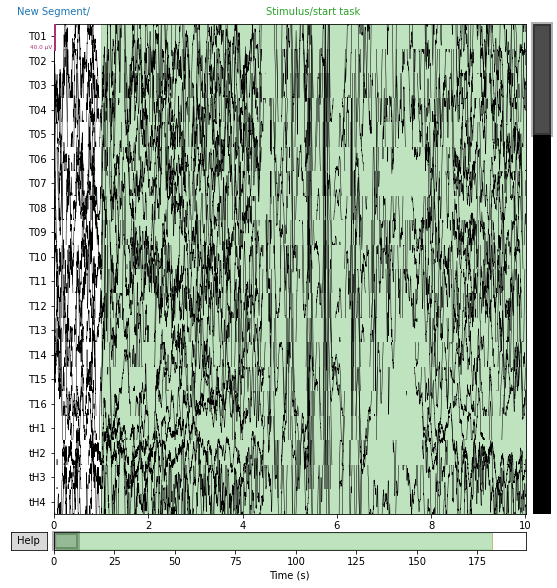

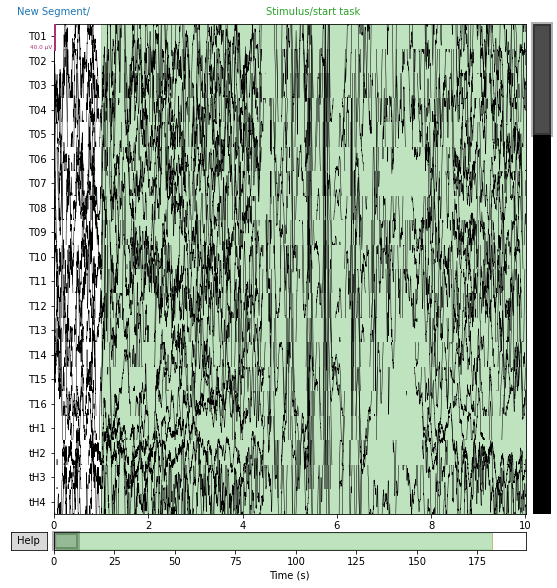

In [7]:
raw.plot()

In [ ]:
# data = raw.get_data()
# print(data.shape)
# plt.plot(data[0,:])

## Read the channel and electrode information

In [8]:
channels = pd.read_csv(channel_path, delimiter='\t')
channels.head()

,name,type,units,low_cutoff,high_cutoff,reference,group,status,status_description,sampling_frequency
0,T01,ECOG,µV,NaN,0.15,G2,T,good,NaN,512.0
1,T02,ECOG,µV,0.0,0.15,G2,T,good,NaN,512.0
2,T03,ECOG,µV,0.0,0.15,G2,T,good,NaN,512.0
3,T04,ECOG,µV,0.0,0.15,G2,T,good,NaN,512.0
4,T05,ECOG,µV,0.0,0.15,G2,T,good,NaN,512.0


In [50]:
non_ecog = channels['name'][channels['type'] != 'ECOG'].to_list()
print('Non-ecog channels: ', non_ecog)
bad_chans = channels['name'][channels['status'] == 'bad'].to_list()
print('Bad ecog channels: ', bad_chans)
chans2drop = non_ecog + bad_chans
print(chans2drop)

Non-ecog channels:  ['MKR1+', 'ECG+', 'emg+', 'R1+', 'R2+', 'thor+', 'abdo+', 'MKR2+']
Bad ecog channels:  ['F41', 'F46', 'FB57', 'FB62', 'MKR1+', 'aT8', 'sT7', 'sT8']
['MKR1+', 'ECG+', 'emg+', 'R1+', 'R2+', 'thor+', 'abdo+', 'MKR2+', 'F41', 'F46', 'FB57', 'FB62', 'MKR1+', 'aT8', 'sT7', 'sT8']


In [54]:
raw.drop_channels(chans2drop)

<RawBrainVision | sub-45_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 73 x 99769 (194.9 s), ~55.6 MB, data loaded>

In [58]:
elec_path = f'{data_dir}/sub-{subj}_ses-{sess}_acq-{acq}_electrodes.tsv'
electrodes = pd.read_csv(elec_path, delimiter = '\t', index_col='name')
electrodes

,x,y,z,size
name,,,,
T01,-44.604,37.135,-23.889,NaN
T02,-57.604,36.135,-22.889,NaN
T03,-63.604,25.135,-23.889,NaN
T04,-69.604,14.135,-22.889,NaN
T05,-74.604,4.135,-21.889,NaN
...,...,...,...,...
sT4,-47.604,18.135,-42.889,NaN
sT5,-55.604,14.135,-40.889,NaN
sT6,-61.604,10.135,-34.889,NaN


In [68]:
coords = electrodes.copy().drop(columns = ['size'])
row2drop = set(coords.index) & set(chans2drop)
coords = coords.drop(index = row2drop)
coords.shape

(73, 3)

In [69]:
coords_dict = coords.T.to_dict('list')

In [70]:
coords_dict.keys()

dict_keys(['T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'tH1', 'tH2', 'tH3', 'tH4', 'tH5', 'tH6', 'tH7', 'tH8', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F42', 'F43', 'F44', 'F45', 'F47', 'F48', 'FB49', 'FB50', 'FB51', 'FB52', 'FB53', 'FB54', 'FB55', 'FB56', 'FB58', 'FB59', 'FB60', 'FB61', 'FB63', 'FB64', 'vT1', 'vT2', 'vT3', 'vT4', 'vT5', 'vT6', 'vT7', 'vT8', 'aT1', 'aT2', 'aT3', 'aT4', 'aT5', 'aT6', 'aT7', 'sT1', 'sT2', 'sT3', 'sT4', 'sT5', 'sT6'])

In [71]:
montage = mne.channels.make_dig_montage(ch_pos = coords_dict)

In [72]:
raw.set_montage(montage)

/tmp/ipykernel_6062/546628248.py:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<RawBrainVision | sub-45_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 73 x 99769 (194.9 s), ~55.7 MB, data loaded>

1 duplicate electrode labels found:
tH1/FB51
Plotting 72 unique labels.
Creating RawArray with float64 data, n_channels=72, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


/tmp/ipykernel_6062/988898452.py:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage)


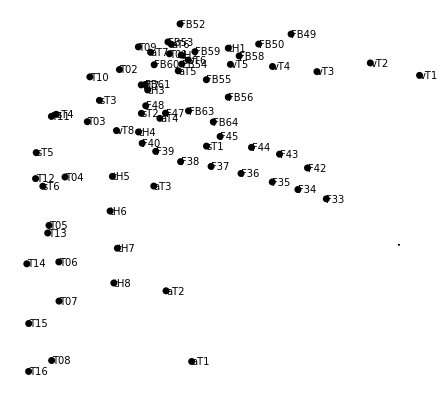

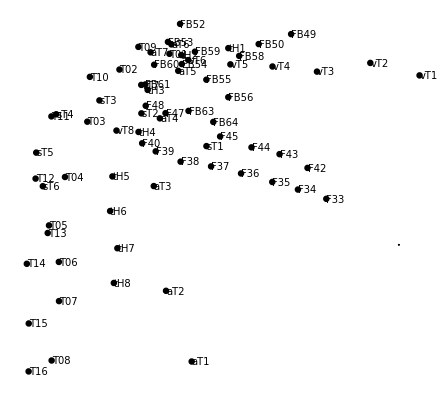

In [73]:
mne.viz.plot_montage(montage)